
# Machine Learning Engineer Nanodegree

### Capstone Project: Starbucks’ Capstone Challenge - Notebook 1.

***Maria Balog  
May 8th, 2020***

## Introduction

#### Domain Background

In this project we analyze simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks, also, not all users receive the same offer .

#### Problem Statement

Our task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This can be achieved by joining the three sets of data based on their matching IDs (or in some cases considering the offer duration), and applying unsupervised machine learning algorithms to divide the data into distinct categories. Our data set is a simplified version of the real Starbucks app because the underlying simulator has only one product whereas Starbucks actually sells dozens of products.

To give an example, a user could receive a discount offer "buy 10 dollars get 2 off" on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, a user can receive an offer, never actually view the offer, and still complete it by spending the required minimum amount, so there would be an offer completion record in the data set, even if the customer was not influenced by the offer. Also, some people may respond negatively, that is, sometimes people don’t want to be sent so many offers, so sometimes the best thing to do is to not send something.

We also need to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, we wouldn't want to send a buy 10 dollars get 2 dollars off offer. So we also need to try to assess what a certain demographic group will buy when not receiving any offers.

These behaviors are clearly indicated by the event and value fields in the transcript data set, so our data can first be filtered based on what behavior we wish to target. 

Our main areas of query for this project will be, for what demographic groups and what offer types  
- are offers most likely to be viewed within their valid duration?
- are offers most likely to be completed, given that they were viewed?
- can we find a correlation between an offer being viewed and the total amount of transactions within the duration of the offer?


### Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

## Implementation


The implementation of the solution consists of the following steps:
- data cleaning and visualization
- feature engineering
- applying unsupervised ML algorithms to various subsets of the data
- validating and analyzing the results
- summarizing the results and conclusion

In this notebook, we will focus on the first step: **data cleaning and visualization**.

### Data Exploration

First, let's import all the necessary modules and explore the data.


In [1]:
import pandas as pd
import numpy as np
import math
import json

import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
columns = ['id', 'channels', 'offer_type', 'duration', 'difficulty', 'reward']
portfolio[columns]

,id,channels,offer_type,duration,difficulty,reward
0,ae264e3637204a6fb9bb56bc8210ddfd,"[email, mobile, social]",bogo,7,10,10
1,4d5c57ea9a6940dd891ad53e9dbe8da0,"[web, email, mobile, social]",bogo,5,10,10
2,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",informational,4,0,0
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",bogo,7,5,5
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,"[web, email]",discount,10,20,5
5,2298d6c36e964ae4a3e7e9706d1fb8c2,"[web, email, mobile, social]",discount,7,7,3
6,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",discount,10,10,2
7,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",informational,3,0,0
8,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",bogo,5,5,5
9,2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",discount,7,10,2


The `portfolio` dataframe looks fairly straightforward, all we need to do is one-hot encode the `channels` and `offer_type` columns. Also, since there are only ten kinds of offers in our dataset, there is no point in keeping a 16-byte id column -- it would make sense to replace it with something more human-readable in both the `portfilio` and `transcript` dataframes. For example, a buy-one-get-one offer with seven days duration and five dollars spending could be encoded as `bogo_7d_5`.

In [3]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


The `profile` dataframe seems to have a lot of invalid data, from the first few rows it seems like several users don't have meaningful `age`, `gender` and `income` values. Let's see if the missing data coincides in the rest of the dataframe.

In [4]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

print('Missing age data: {} rows.'.format(profile[profile['age']==118].shape[0]))
print('Missing gender data: {} rows.'.format(profile[profile['gender'].isnull()].shape[0]))
print('Missing income data: {} rows.'.format(profile[profile['income'].isnull()].shape[0]))
print('Coinciding missing data: {} rows.'.format(profile[profile['age']==118][profile['gender'].isnull()][profile['income'].isnull()].shape[0]))

profile[profile['age']==118].sort_values(by=['became_member_on']).head()

Missing age data: 2175 rows.
Missing gender data: 2175 rows.
Missing income data: 2175 rows.
Coinciding missing data: 2175 rows.


,gender,age,id,became_member_on,income
13541,None,118,e431ebcc6f944c5c9a2d93cbd4a790d7,20130802,NaN
2886,None,118,b685bf9de0794b44ba299464a95aa679,20130810,NaN
2796,None,118,405abb415d4b44379feec2185f49cee3,20130824,NaN
13344,None,118,b7dc974d1a5e4790b8e5eea0410efbf2,20130824,NaN
8066,None,118,24ed163d8e0d467fb01eda3d6fd78528,20130920,NaN


It seems like it does. Out of the 17,000 rows in the `profile` dataframe, 2175 rows only contain the user's id and the date they became a member on. For now, we will ignore these rows, and only work with the rest of the dataframe, which looks pretty consistent:

In [5]:
profile[profile['age'] < 118].describe().round(4)

,age,became_member_on,income
count,14825.0000,1.482500e+04,14825.0000
mean,54.3935,2.016689e+07,65404.9916
std,17.3837,1.188565e+04,21598.2994
min,18.0000,2.013073e+07,30000.0000
25%,42.0000,2.016052e+07,49000.0000
50%,55.0000,2.017080e+07,64000.0000
75%,66.0000,2.017123e+07,80000.0000
max,101.0000,2.018073e+07,120000.0000


Of course, we still need to perform some preprocessing steps, such as one-hot encoding on the gender column and converting `became_member_on` values to `days_of_membership`.

Next, we can look at the `transcript` data, which can be broken down by the four types of events: `offer received`, `offer viewed`, `transaction` and `offer completed`. Here we omit the `id` column for clearer display.

In [6]:
tr = transcript[['event', 'time', 'value']]
print('# of offers received: {}'.format(tr[tr['event'] == 'offer received'].shape[0]))
tr[tr['event'] == 'offer received'].head()

# of offers received: 76277


,event,time,value
0,offer received,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [7]:
print('\n# of offers viewed: {}'.format(tr[tr['event'] == 'offer viewed'].shape[0]))
tr[tr['event'] == 'offer viewed'].head()


# of offers viewed: 57725


,event,time,value
12650,offer viewed,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651,offer viewed,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652,offer viewed,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
12653,offer viewed,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12655,offer viewed,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}


In [8]:
print('\n# of transactions: {}'.format(tr[tr['event'] == 'transaction'].shape[0]))
tr[tr['event'] == 'transaction'].head()


# of transactions: 138953


,event,time,value
12654,transaction,0,{'amount': 0.8300000000000001}
12657,transaction,0,{'amount': 34.56}
12659,transaction,0,{'amount': 13.23}
12670,transaction,0,{'amount': 19.51}
12671,transaction,0,{'amount': 18.97}


In [9]:
print('\n# of offers completed: {}'.format(tr[['value']][tr['event'] == 'offer completed'].shape[0]))
tr[['value']][tr['event'] == 'offer completed'].head()


# of offers completed: 33579


,value
12658,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12672,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
12679,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
12692,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
12697,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...


It's also worth looking at the timestamps each event was recorded. It turns out, that the data was recorded in regular six-hour intervals:

In [10]:
print('Offers received at (hours): ', transcript[transcript['event'] == 'offer received'].time.unique())
print('Offers viewed at (hours): ', transcript[transcript['event'] == 'offer viewed'].time.unique())
print('Tranactions at (hours): ', transcript[transcript['event'] == 'transaction'].time.unique())
print('Offers completed at (hours): ', transcript[transcript['event'] == 'offer completed'].time.unique())

Offers received at (hours):  [  0 168 336 408 504 576]
Offers viewed at (hours):  [  0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 102
 108 114 120 126 132 138 144 150 156 162 168 174 180 186 192 198 204 210
 216 222 228 234 240 246 252 258 264 270 276 282 288 294 300 306 312 318
 324 330 336 342 348 354 360 366 372 378 384 390 396 402 408 414 420 426
 432 438 444 450 456 462 468 474 480 486 492 498 504 510 516 522 528 534
 540 546 552 558 564 570 576 582 588 594 600 606 612 618 624 630 636 642
 648 654 660 666 672 678 684 690 696 702 708 714]
Tranactions at (hours):  [  0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 102
 108 114 120 126 132 138 144 150 156 162 168 174 180 186 192 198 204 210
 216 222 228 234 240 246 252 258 264 270 276 282 288 294 300 306 312 318
 324 330 336 342 348 354 360 366 372 378 384 390 396 402 408 414 420 426
 432 438 444 450 456 462 468 474 480 486 492 498 504 510 516 522 528 534
 540 546 552 558 564 570 576 582 588 594

### Visualizing the Transcript Dataset

Above, we can see that offers were received 
- at the zero mark, 
- at one week, 
- at two weeks,
- at two weeks and three days, 
- at the three weeks mark, and 
- at three weeks and three days. 

Let's look at the approximate number of all `events` occuring during this time period.   

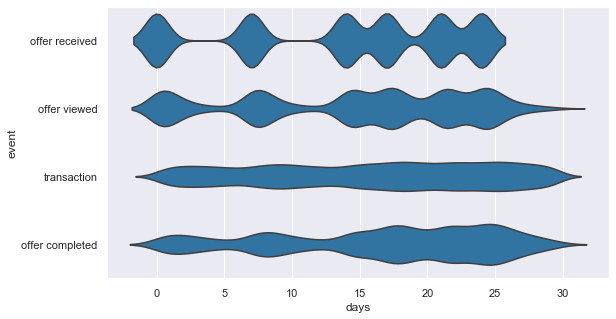

In [11]:
import sys  
sys.path.insert(0, './source')
import sb_data_visualization as dv

dv.display_transcript(transcript)

This looks like what we would expect: most offers were viewed within a day or so after being received, the transactions (purchases) are slightly affected by the offers viewed, and the offers completed also seem to correspond with the other events with a slight delay.

### Visualizing the User Data

As mentioned above, there are a little over two thousand datapoints in the`profile` dataframe that have no meaningful demographic information, so let's remove those first.

In [12]:
profile.dropna(inplace=True)
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
gender              14825 non-null object
age                 14825 non-null int64
id                  14825 non-null object
became_member_on    14825 non-null int64
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB


In [13]:
profile.describe().round(2)

,age,became_member_on,income
count,14825.00,14825.00,14825.00
mean,54.39,20166887.15,65404.99
std,17.38,11885.65,21598.30
min,18.00,20130729.00,30000.00
25%,42.00,20160520.00,49000.00
50%,55.00,20170802.00,64000.00
75%,66.00,20171230.00,80000.00
max,101.00,20180726.00,120000.00


We successfully eliminated all the invalid/missing data, and we can see we have three numerical columns to work with. The distribution of the data looks fairly reasonable, with no extreme outliers (although a bunch of centenarians hanging out at Starbucks is a bit hard to imagine ;)

First we can look at if there is any correlation between the `age` and the `income` of these members.

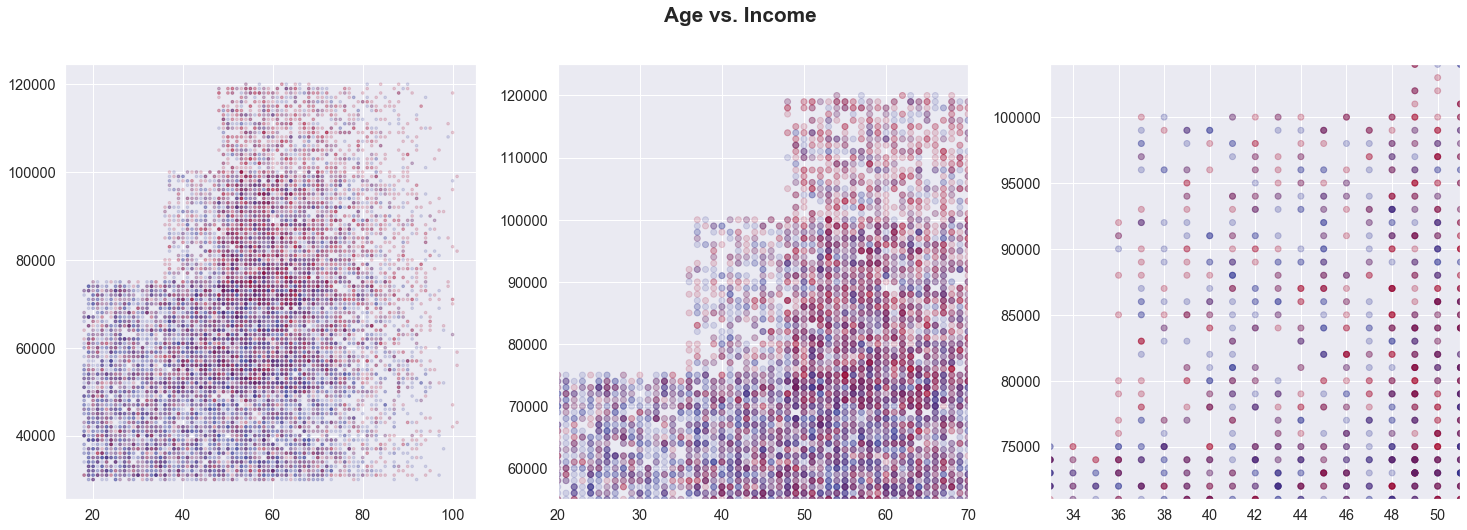

In [14]:
dv.display_profile(profile.copy())

Based on these visualizations, there are some clear patterns in this data: members under 35 years of age all make less than 80K a year, and they make no more than around 100K until their late 40's. I guess no young data scientists signed up for Starbucks rewards at the time ;)

We can further examine the disrtibution of `age`, `income` and duration of membership, broken down by `genders`, using the following charts.

#### *Distribution of Age by Gender*

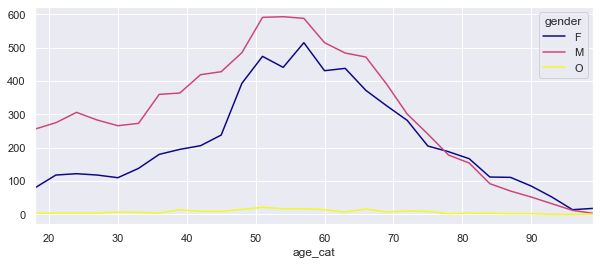

In [15]:
dv.display_age_by_gender(profile)

#### *Distribution of Income by Gender*

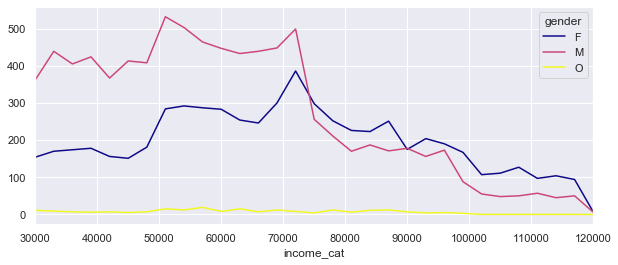

In [16]:
dv.display_income_by_gender(profile)

#### *Distribution of Membership Duration by Gender*

For this last chart we can first calculate how long a has person been member at the time of the data collection.

In [17]:
# this is the last modified date on the json files, seems like a good enough approximation
base_date = pd.Timestamp('2018-10-20')
dv.calculate_member_days(profile, base_date)
profile.describe().round(2)

,age,income,member_days
count,14825.00,14825.00,14825.00
mean,54.39,65404.99,608.48
std,17.38,21598.30,419.21
min,18.00,30000.00,86.00
25%,42.00,49000.00,294.00
50%,55.00,64000.00,444.00
75%,66.00,80000.00,883.00
max,101.00,120000.00,1909.00


This seems reasonable, the membership-to-date values range between about two months and five years, with an average of a little less than two years. 


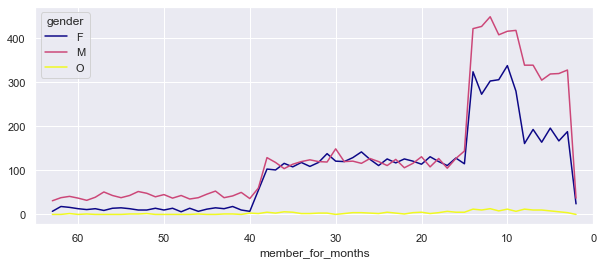

In [18]:
dv.display_membership_by_gender(profile, base_date)

It looks like people became members in three waves, the first wave was from over five years till about fourty months before the data collection, the second wave happened about fourty months to fifteen months before, and the third wave betwen 15 months and two months before.

#### *So what did we learn from all this?*

This is clearly a simulated data meant to facilitate the development of ML models, with clear trends of changes in `income` levels as the function of `age`, as well as waves of new members joining the program, as suggested by this last chart. 
The distribution of the `income` data is slightly right skewed, while the distribution of length of membership is left skewed, as to be expected.

###   Data Cleaning and Preprocessing

***Portfolio Dataset***

Let's start by one-hot encoding the `channels` and `offer_type` columns in the `portfolio` dataframe and creating a human-readable id.

In [19]:
import sb_data_wrangling as dw

# here we need to save the mapping between the 16 byte hashcodes and human-readable offer_ids
id_to_my_id = dw.clean_portfolio(portfolio)
portfolio.head(10)

,reward,difficulty,duration,web,email,mobile,social,bogo,info,disc
my_id,,,,,,,,,,
bogo_7d_10,10,10,7,0,1,1,1,1,0,0
bogo_5d_10,10,10,5,1,1,1,1,1,0,0
info_4d_0,0,0,4,1,1,1,0,0,1,0
bogo_7d_5,5,5,7,1,1,1,0,1,0,0
disc_10d_20,5,20,10,1,1,0,0,0,0,1
disc_7d_7,3,7,7,1,1,1,1,0,0,1
disc_10d_10,2,10,10,1,1,1,1,0,0,1
info_3d_0,0,0,3,0,1,1,1,0,1,0
bogo_5d_5,5,5,5,1,1,1,1,1,0,0


***Profile Dataset***

All we need to do here is one-hot encode the `gender` column, since we already converted the `became_member_on` date to number of days passed since becoming a member in the visualization section.

In [20]:
# print out additional info
print('Unique values in gender column: {}\n'.format(profile.gender.unique()))
profile.describe().round(2)


Unique values in gender column: ['F' 'M' 'O']



,age,income,member_days
count,14825.00,14825.00,14825.00
mean,54.39,65404.99,608.48
std,17.38,21598.30,419.21
min,18.00,30000.00,86.00
25%,42.00,49000.00,294.00
50%,55.00,64000.00,444.00
75%,66.00,80000.00,883.00
max,101.00,120000.00,1909.00


In [21]:
profile.head()

,gender,age,id,income,member_days
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,462
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,529
5,M,68,e2127556f4f64592b11af22de27a7932,70000.0,177
8,M,65,389bc3fa690240e798340f5a15918d5c,53000.0,253
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,343


In [22]:
dw.clean_profile(profile)
profile.head()

,age,income,member_days,female,male,other
id,,,,,,
0610b486422d4921ae7d2bf64640c50b,55,112000.0,462,1,0,0
78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,529,1,0,0
e2127556f4f64592b11af22de27a7932,68,70000.0,177,0,1,0
389bc3fa690240e798340f5a15918d5c,65,53000.0,253,0,1,0
2eeac8d8feae4a8cad5a6af0499a211d,58,51000.0,343,0,1,0


***Transcript Dataset***

Now it's time to clean up and preprocess the `transcript` dataframe which contains four types of events, namely: `offer received`, `offer viewed`, `transaction`, `offer completed`. 

The main questions we are trying to answer with this project are:

For what demographic groups and what offer types  
- are offers most likely to be viewed within their valid duration?
- are offers most likely to be completed, given that they were viewed?
- can we find a correlation between an offer being viewed and the total amount of transactions within the duration of the offer?

Since these questions examine certain types of events independently from other events, it would make sense to first create a new dataframe for each event type, and later join the appropriate dataframes as necessary. Other preprocessing steps include replacing the value column with the attribute(s) inside the value column, and replacing the `offer_id`'s with their human-readable counterparts.

In [23]:
# create new dataframe for offer received events only
offer_received = pd.DataFrame(transcript[transcript['event'] == 'offer received'])
offer_received.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76277 entries, 0 to 257886
Data columns (total 4 columns):
person    76277 non-null object
event     76277 non-null object
value     76277 non-null object
time      76277 non-null int64
dtypes: int64(1), object(3)
memory usage: 2.9+ MB


In [24]:
offer_received.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


It looks like the only key in the `value` dictionaries is `offer id`. We need to extract these values and convert them into our human-readable ids, then drop all the unnecessary columns.

In [25]:
offer_ids = [id_to_my_id.get(row['value'].get('offer id')) for ind, row in offer_received.iterrows()]
offer_received['offer_id'] = offer_ids

offer_received.drop(columns=['event', 'value'], inplace=True)
offer_received.head()

,person,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,0,bogo_7d_5
1,a03223e636434f42ac4c3df47e8bac43,0,disc_10d_20
2,e2127556f4f64592b11af22de27a7932,0,disc_7d_10
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,disc_10d_10
4,68617ca6246f4fbc85e91a2a49552598,0,bogo_5d_10


Next, repeat these steps for `offer viewed` events.

In [26]:
# create new dataframe for offer viewed events only
offer_viewed = pd.DataFrame(transcript[transcript['event'] == 'offer viewed'])
print(offer_viewed.info())
offer_viewed.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57725 entries, 12650 to 306507
Data columns (total 4 columns):
person    57725 non-null object
event     57725 non-null object
value     57725 non-null object
time      57725 non-null int64
dtypes: int64(1), object(3)
memory usage: 2.2+ MB
None


,person,event,value,time
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0
12652,102e9454054946fda62242d2e176fdce,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
12653,02c083884c7d45b39cc68e1314fec56c,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0


Again, it looks like the only key in the `value` dictionaries is `offer id`. We need to extract these values and convert them into our human-readable ids, then drop all the unnecessary columns.

In [27]:
offer_ids = [id_to_my_id.get(row['value'].get('offer id')) for ind, row in offer_viewed.iterrows()]
offer_viewed['offer_id'] = offer_ids

offer_viewed.drop(columns=['event', 'value'], inplace=True)
offer_viewed.head()

,person,time,offer_id
12650,389bc3fa690240e798340f5a15918d5c,0,bogo_5d_5
12651,d1ede868e29245ea91818a903fec04c6,0,info_3d_0
12652,102e9454054946fda62242d2e176fdce,0,bogo_5d_10
12653,02c083884c7d45b39cc68e1314fec56c,0,bogo_7d_10
12655,be8a5d1981a2458d90b255ddc7e0d174,0,info_3d_0


Next, we repeat the same steps for `transaction` events.

In [28]:
# create new dataframe for transaction events only
transaction = pd.DataFrame(transcript[transcript['event'] == 'transaction'])
print(transaction.info())
transaction.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138953 entries, 12654 to 306533
Data columns (total 4 columns):
person    138953 non-null object
event     138953 non-null object
value     138953 non-null object
time      138953 non-null int64
dtypes: int64(1), object(3)
memory usage: 5.3+ MB
None


,person,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0


This time the only key in the value dictionaries is `amount`. We need to extract these values and drop all the unnecessary columns.

In [29]:
amounts = [row['value'].get('amount') for ind, row in transaction.iterrows()]
transaction['amount'] = amounts
transaction.drop(columns=['event', 'value'], inplace=True)

transaction.describe().round(2)


,time,amount
count,138953.00,138953.00
mean,381.58,12.78
std,201.70,30.25
min,0.00,0.05
25%,210.00,2.78
50%,402.00,8.89
75%,552.00,18.07
max,714.00,1062.28


In [30]:
transaction.head()

,person,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,54890f68699049c2a04d415abc25e717,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


This data looks a bit suspicious, the minimum amount spent in a transaction is 5 cents, while the maximum amount is over a thousand dollars, which seems fairly unusual for a trip to Starbucks. We will further examine these outliers in the following notebooks. 

For now, let's repeat the same preprocessing steps for ``offer completed`` events.

In [31]:
# create new dataframe for offer completed events only
offer_completed = pd.DataFrame(transcript[transcript['event'] == 'offer completed'])

print('Checking random records in offer_completed: {}'.format(offer_completed.iloc[10, 2]))
offer_completed.describe().round(2)


Checking random records in offer_completed: {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}


,time
count,33579.00
mean,401.05
std,192.35
min,0.00
25%,240.00
50%,432.00
75%,564.00
max,714.00


In [32]:
offer_completed.head()

,person,event,value,time
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0
12692,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0


After checking a few random `values`, it looks like there are two keys in the `value` dictionaries: `offer_id` and `reward`. We need to extract these values, and convert the `offer_id`'s into our human-readable ids, then drop all the unnecessary columns.

In [33]:
offer_ids = [id_to_my_id.get(row['value'].get('offer_id')) for ind, row in offer_completed.iterrows()]
offer_completed['offer_id'] = offer_ids

rewards = [row['value'].get('reward') for ind, row in offer_completed.iterrows()]
offer_completed['reward'] = rewards

offer_completed.drop(columns=['event', 'value'], inplace=True)
offer_completed.head()

,person,time,offer_id,reward
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,disc_7d_10,2
12672,fe97aa22dd3e48c8b143116a8403dd52,0,disc_10d_10,2
12679,629fc02d56414d91bca360decdfa9288,0,bogo_7d_5,5
12692,676506bad68e4161b9bbaffeb039626b,0,bogo_7d_10,10
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,bogo_5d_10,10


### Section Summary

So far, we have performed some data cleaning and preprocessing steps, and created six dataframes that only contain id columns and numerical data. We will now save them as `.csv` files, and move on to the [next notebook](Starbucks_Capstone_notebook3.ipynb), dedicated to further data processing and feature selection.

In [34]:
# save all preprocessed data to csv files
portfolio.to_csv('data/portfolio.csv', index_label='offer_id')
profile.to_csv('data/profile.csv', index_label='person')
offer_received.to_csv('data/offer_received.csv', index=False)
offer_viewed.to_csv('data/offer_viewed.csv', index=False)
transaction.to_csv('data/transaction.csv', index=False)
offer_completed.to_csv('data/offer_completed.csv', index=False)